# Kaggle Titanic

In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
#chargement du fichier 
df_titanic = pd.read_csv('train.csv')
df_titanic.sample(10)

PassengerId  Survived  Pclass  \
25            26         1       3   
352          353         0       3   
3              4         1       1   
349          350         0       3   
2              3         1       3   
387          388         1       2   
495          496         0       3   
514          515         0       3   
498          499         0       1   
519          520         0       3   

                                                  Name     Sex   Age  SibSp  \
25   Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.0      1   
352                                 Elias, Mr. Tannous    male  15.0      1   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
349                                   Dimic, Mr. Jovan    male  42.0      0   
2                               Heikkinen, Miss. Laina  female  26.0      0   
387                                   Buss, Miss. Kate  female  36.0      0   
495                              Yousseff, Mr. Gerious    male   NaN      0   
514                                  Coleff, Mr. Satio    male  24.0      0   
498    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0      1   
519                                Pavlovic, Mr. Stefo    male  32.0      0   

     Parch            Ticket      Fare    Cabin Embarked  
25       5            347077   31.3875      NaN        S  
352      1              2695    7.2292      NaN        C  
3        0            113803   53.1000     C123        S  
349      0            315088    8.6625      NaN        S  
2        0  STON/O2. 3101282    7.9250      NaN        S  
387      0             27849   13.0000      NaN        S  
495      0              2627   14.4583      NaN        C  
514      0            349209    7.4958      NaN        S  
498      2            113781  151.5500  C22 C26        S  
519      0            349242    7.8958      NaN        S

# On boucle des plots sur les colonnes pour choisir les données pertinentes

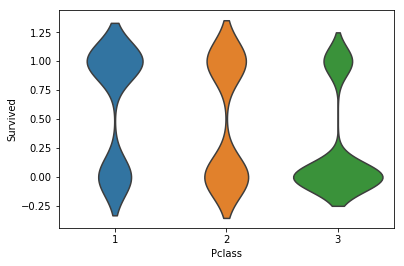

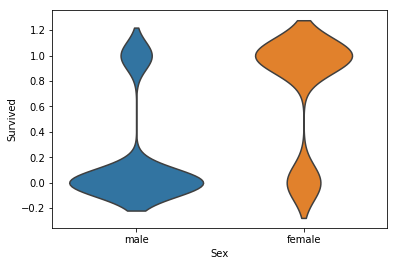

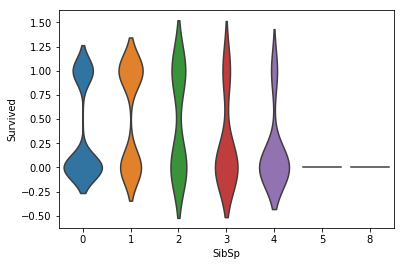

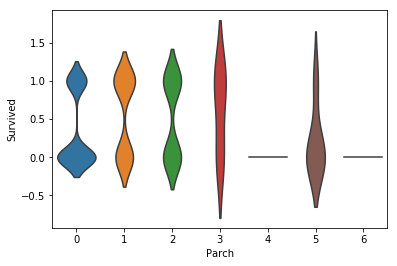

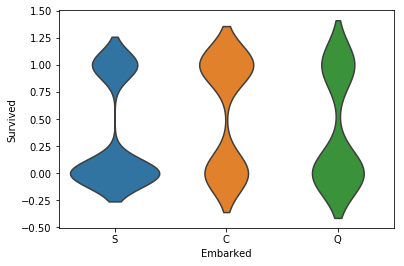

In [3]:
for col in df_titanic.loc[:,['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']].columns:
    sns.violinplot(x=col, y='Survived', data=df_titanic,  inner=None)
    plt.show()

# On prépare les données

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


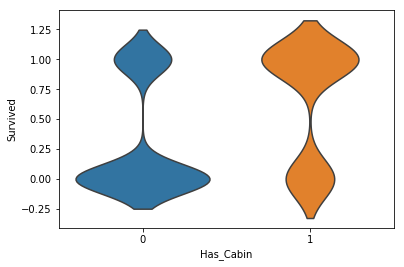

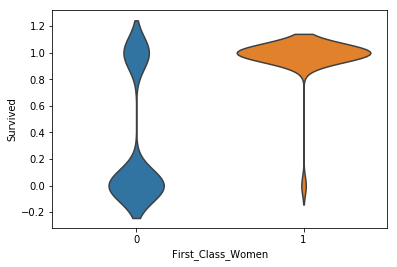

In [4]:
#fonction préparation des données, dans une fonction pour pouvoir faire toutes les transformations sur le fichier
# test aussi

#après avoir fait .corr() sur notre df pour savoir quelles colonnes utiliser aussi, et .describe()
#et .info() pour voir les valeurs manquantes

#correlation = df.corr()
#correlation = correlation['Survived'].abs().sort_values(ascending= False)

#group_type = df_titanic_train.columns.to_series().groupby(df_titanic_train.dtypes).groups
#print('columns type =', group_type)

#list_obj = list(df_titanic_train.select_dtypes(include=['O']).columns) (exclude existe !!)
#list_num = list(df_titanic_train.select_dtypes(include=['int64', 'float64']).columns)

#df_test = pd.read_csv('train.csv')

def prepare_data(df, verbose):
    df['Age'] = df['Age'].fillna(df['Age'].median()) #remplace les NaN dans Age et Fare par 
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())# la valeur médiane. Pour Age, comme il en manque beaucoup
                                                    # on aurait pu créer une nouvelle catégorie d'âge 'inconnu'
    df['Embarked']=df['Embarked'].fillna('S') #car S est le port le plus fréquent et il manque peu de valeurs
  
    def has_cabin(cabin):
        if type(cabin) == type(1.3):
            return 0
        return 1
 
    df['Has_Cabin'] = df['Cabin'].map(has_cabin)
    if verbose:
        sns.violinplot(x='Has_Cabin', y='Survived', data=df,  inner=None)
        plt.show()
        df = df.loc[:,['Survived', 'Pclass', 'Age', 'Sex', 'SibSp', 'Parch', 'Fare', 'Has_Cabin', 'Embarked']]
    else:
        df = df.loc[:,['Pclass', 'Age', 'Sex', 'SibSp', 'Parch', 'Fare', 'Has_Cabin', 'Embarked']]
    
    df = pd.get_dummies(df) #one hot encoding
    df['First_Class_Women'] = np.where((df['Sex_female'] == 1) & (df['Pclass'] == 1), 1, 0)
    
    if verbose:
        sns.violinplot(x='First_Class_Women', y='Survived', data=df,  inner=None)
        plt.show()
    
    return df
print(df_titanic.columns)
df_titanic = prepare_data(df_titanic, True)

# On entraîne le modèle

In [19]:
list_col = ['Pclass', 'Age', 'Sex_female', 'Has_Cabin', 'Fare', 'First_Class_Women',
            'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Parch', 'SibSp'] #colonnes qui nous intéressent
x = df_titanic[list_col]
X = preprocessing.scale(x)
Y = df_titanic['Survived']


X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2)

if False:
    for c in np.arange(0.1, 10, 0.1):
        #linear logistic regression
        logi_reg = lm.LogisticRegression(C=c)
        logi_reg.fit(X_train, np.ravel(Y_train))
        print('linear:', c, ': ' , logi_reg.score(X_valid, np.ravel(Y_valid)))
else:
    c = 0.036
    logi_reg = lm.LogisticRegression(C=c)
    logi_reg.fit(X_train, np.ravel(Y_train))    
    print('linear: ', logi_reg.score(X_valid, np.ravel(Y_valid)))
#tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)
print('tree: ', clf.score(X_valid, Y_valid))

linear:  0.8268156424581006
tree:  0.8324022346368715


# Prédictions

In [6]:
df_test = pd.read_csv('test.csv')
passenger_id_tmp = df_test['PassengerId']

df_test = prepare_data(df_test, False)
df_test

Pclass   Age  SibSp  Parch      Fare  Has_Cabin  Sex_female  Sex_male  \
0         3  34.5      0      0    7.8292          0           0         1   
1         3  47.0      1      0    7.0000          0           1         0   
2         2  62.0      0      0    9.6875          0           0         1   
3         3  27.0      0      0    8.6625          0           0         1   
4         3  22.0      1      1   12.2875          0           1         0   
5         3  14.0      0      0    9.2250          0           0         1   
6         3  30.0      0      0    7.6292          0           1         0   
7         2  26.0      1      1   29.0000          0           0         1   
8         3  18.0      0      0    7.2292          0           1         0   
9         3  21.0      2      0   24.1500          0           0         1   
10        3  27.0      0      0    7.8958          0           0         1   
11        1  46.0      0      0   26.0000          0           0         1   
12        1  23.0      1      0   82.2667          1           1         0   
13        2  63.0      1      0   26.0000          0           0         1   
14        1  47.0      1      0   61.1750          1           1         0   
15        2  24.0      1      0   27.7208          0           1         0   
16        2  35.0      0      0   12.3500          0           0         1   
17        3  21.0      0      0    7.2250          0           0         1   
18        3  27.0      1      0    7.9250          0           1         0   
19        3  45.0      0      0    7.2250          0           1         0   
20        1  55.0      1      0   59.4000          0           0         1   
21        3   9.0      0      1    3.1708          0           0         1   
22        1  27.0      0      0   31.6833          0           1         0   
23        1  21.0      0      1   61.3792          0           0         1   
24        1  48.0      1      3  262.3750          1           1         0   
25        3  50.0      1      0   14.5000          0           0         1   
26        1  22.0      0      1   61.9792          1           1         0   
27        3  22.5      0      0    7.2250          0           0         1   
28        1  41.0      0      0   30.5000          1           0         1   
29        3  27.0      2      0   21.6792          0           0         1   
..      ...   ...    ...    ...       ...        ...         ...       ...   
388       3  21.0      0      0    7.7500          0           0         1   
389       3   6.0      3      1   21.0750          0           0         1   
390       1  23.0      0      0   93.5000          1           0         1   
391       1  51.0      0      1   39.4000          1           1         0   
392       3  13.0      0      2   20.2500          0           0         1   
393       2  47.0      0      0   10.5000          0           0         1   
394       3  29.0      3      1   22.0250          0           0         1   
395       1  18.0      1      0   60.0000          1           1         0   
396       3  24.0      0      0    7.2500          0           0         1   
397       1  48.0      1      1   79.2000          1           1         0   
398       3  22.0      0      0    7.7750          0           0         1   
399       3  31.0      0      0    7.7333          0           0         1   
400       1  30.0      0      0  164.8667          1           1         0   
401       2  38.0      1      0   21.0000          0           0         1   
402       1  22.0      0      1   59.4000          0           1         0   
403       1  17.0      0      0   47.1000          0           0         1   
404       1  43.0      1      0   27.7208          1           0         1   
405       2  20.0      0      0   13.8625          1           0         1   
406       2  23.0      1      0   10.5000          0           0         1   
407       1  50.0      1   

In [7]:
X_test = df_test.loc[:, list_col]
result = logi_reg.predict(X_test)
result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Création du CSV

In [8]:
data = pd.DataFrame({'PassengerId':passenger_id_tmp, 'Survived': result})
data.set_index('PassengerId').to_csv('my_test.csv')

In [ ]:
# revoir barplot au lieu de violinplot
# scaler